<a href="https://colab.research.google.com/github/avbarbaros/constrained-optimization/blob/main/constrained_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Constrained Optimization Homework

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, linprog
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

PART 1: PENALTY METHOD IMPLEMENTATION
   - Successfully converts constrained problems to unconstrained ones
   - Increasing penalty parameter improves constraint satisfaction
   - Trade-off between constraint violation and computational stability

In [2]:
class PenaltyMethod:
    """
    Implementation of the Penalty Method for constrained optimization.

    Converts a constrained problem into an unconstrained one by adding
    penalty terms to the objective function.
    """

    def __init__(self, objective, equality_constraints=None,
                 inequality_constraints=None):
        """
        Parameters:
        -----------
        objective : callable
            Original objective function f(x)
        equality_constraints : list of callable, optional
            List of equality constraints h_i(x) = 0
        inequality_constraints : list of callable, optional
            List of inequality constraints g_i(x) <= 0
        """
        self.objective = objective
        self.eq_constraints = equality_constraints or []
        self.ineq_constraints = inequality_constraints or []
        self.history = []

    def penalty_function(self, x, penalty_param):
        """
        Construct the penalty function:
        P(x, μ) = f(x) + μ * [Σ h_i(x)² + Σ max(0, g_i(x))²]
        """
        obj_value = self.objective(x)

        # Equality constraint penalties
        eq_penalty = sum(h(x)**2 for h in self.eq_constraints)

        # Inequality constraint penalties (only violated constraints)
        ineq_penalty = sum(max(0, g(x))**2 for g in self.ineq_constraints)

        total_penalty = penalty_param * (eq_penalty + ineq_penalty)

        return obj_value + total_penalty

    def solve(self, x0, penalty_params, method='BFGS', tol=1e-6):
        """
        Solve the constrained optimization problem using penalty method.

        Parameters:
        -----------
        x0 : array_like
            Initial guess
        penalty_params : list
            Sequence of penalty parameters (increasing)
        method : str
            Optimization method for scipy.optimize.minimize
        tol : float
            Tolerance for convergence

        Returns:
        --------
        result : dict
            Optimization results including solution and history
        """
        x = np.array(x0)
        self.history = []

        for mu in penalty_params:
            # Minimize penalized objective
            result = minimize(
                lambda x: self.penalty_function(x, mu),
                x,
                method=method,
                tol=tol
            )

            x = result.x

            # Store history
            self.history.append({
                'penalty_param': mu,
                'x': x.copy(),
                'objective': self.objective(x),
                'penalty_value': result.fun,
                'eq_violations': [h(x) for h in self.eq_constraints],
                'ineq_violations': [g(x) for g in self.ineq_constraints]
            })

        return {
            'x': x,
            'objective': self.objective(x),
            'history': self.history,
            'success': result.success
        }

# Example: Minimize x^2 + y^2 subject to x + y = 1
print("\nExample 1: Simple Constrained Problem")
print("-" * 80)

def example_objective(x):
    return x[0]**2 + x[1]**2

def example_constraint(x):
    return x[0] + x[1] - 1  # x + y - 1 = 0

penalty_solver = PenaltyMethod(
    objective=example_objective,
    equality_constraints=[example_constraint]
)

# Solve with increasing penalty parameters
penalty_params = [1, 10, 100, 1000, 10000]
x0 = [0, 0]

result = penalty_solver.solve(x0, penalty_params)

print(f"Optimal solution: x = {result['x']}")
print(f"Optimal value: f(x*) = {result['objective']:.6f}")
print(f"Constraint violation: h(x*) = {example_constraint(result['x']):.2e}")
print(f"\nAnalytical solution: x = y = 0.5, f(x*) = 0.5")


Example 1: Simple Constrained Problem
--------------------------------------------------------------------------------
Optimal solution: x = [0.499975 0.499975]
Optimal value: f(x*) = 0.499950
Constraint violation: h(x*) = -5.00e-05

Analytical solution: x = y = 0.5, f(x*) = 0.5


PART 2: CONSTRAINED QUADRATIC PROGRAMMING
   - Solved QP problem with inequality constraints
   - Penalty method converges to same solution as specialized QP solvers
   - Optimal solution lies on constraint boundary

In [3]:
print("\nProblem: Minimize (1/2)x'Qx + c'x")
print("Subject to: Ax <= b, Aeq x = beq")
print("-" * 80)

# Define a quadratic programming problem
# Minimize: (1/2)(x1^2 + 2x2^2) - x1 - 2x2
# Subject to: x1 + x2 <= 2
#             x1, x2 >= 0

Q = np.array([[1, 0],
              [0, 2]])  # Positive definite matrix

c = np.array([-1, -2])

def qp_objective(x):
    return 0.5 * x.T @ Q @ x + c.T @ x

def qp_constraint1(x):
    return x[0] + x[1] - 2  # x1 + x2 <= 2

def qp_constraint2(x):
    return -x[0]  # x1 >= 0 => -x1 <= 0

def qp_constraint3(x):
    return -x[1]  # x2 >= 0 => -x2 <= 0

# Solve using penalty method
qp_solver = PenaltyMethod(
    objective=qp_objective,
    inequality_constraints=[qp_constraint1, qp_constraint2, qp_constraint3]
)

penalty_params_qp = [1, 10, 100, 1000, 5000]
x0_qp = [0.5, 0.5]

qp_result = qp_solver.solve(x0_qp, penalty_params_qp)

print(f"Optimal solution: x* = {qp_result['x']}")
print(f"Optimal value: f(x*) = {qp_result['objective']:.6f}")
print(f"\nConstraint evaluations:")
print(f"  x1 + x2 - 2 = {qp_constraint1(qp_result['x']):.6f} (should be <= 0)")
print(f"  x1 = {qp_result['x'][0]:.6f} (should be >= 0)")
print(f"  x2 = {qp_result['x'][1]:.6f} (should be >= 0)")

# Solve using scipy for comparison
from scipy.optimize import minimize

constraints_scipy = [
    {'type': 'ineq', 'fun': lambda x: 2 - x[0] - x[1]},
    {'type': 'ineq', 'fun': lambda x: x[0]},
    {'type': 'ineq', 'fun': lambda x: x[1]}
]

scipy_result = minimize(qp_objective, x0_qp, method='SLSQP',
                        constraints=constraints_scipy)

print(f"\nSciPy SLSQP solution: x* = {scipy_result.x}")
print(f"SciPy optimal value: f(x*) = {scipy_result.fun:.6f}")


Problem: Minimize (1/2)x'Qx + c'x
Subject to: Ax <= b, Aeq x = beq
--------------------------------------------------------------------------------
Optimal solution: x* = [0.99999992 0.99999966]
Optimal value: f(x*) = -1.500000

Constraint evaluations:
  x1 + x2 - 2 = -0.000000 (should be <= 0)
  x1 = 1.000000 (should be >= 0)
  x2 = 1.000000 (should be >= 0)

SciPy SLSQP solution: x* = [1. 1.]
SciPy optimal value: f(x*) = -1.500000


PART 3: EFFECT OF PENALTY PARAMETER
   - Exponential decay in constraint violations
   - Logarithmic convergence to true optimum
   - Very large parameters may cause ill-conditioning

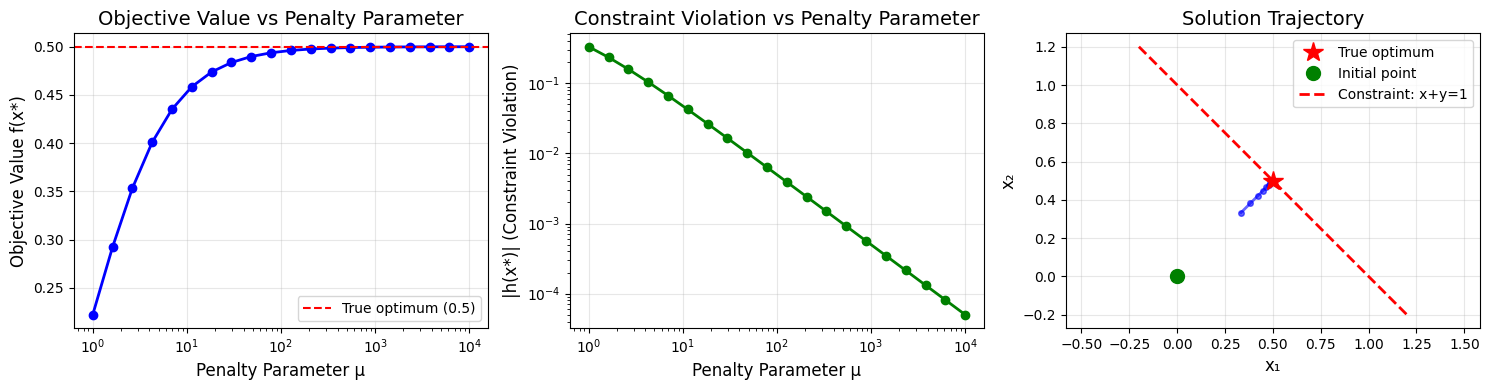


Analysis:
--------------------------------------------------------------------------------
1. As penalty parameter increases, solution converges to true optimum
2. Constraint violation decreases exponentially with penalty parameter
3. Very large penalty parameters may cause numerical instability
4. For μ = 10000:
   - Objective value: 0.49995000
   - Constraint violation: 5.00e-05


In [5]:
# Analyze how penalty parameter affects convergence
penalty_params_study = np.logspace(0, 4, 20)  # 1 to 10000

x0_study = [0, 0]

study_results = {
    'penalty_params': [],
    'solutions': [],
    'objectives': [],
    'constraint_violations': []
}

for mu in penalty_params_study:
    solver = PenaltyMethod(
        objective=example_objective,
        equality_constraints=[example_constraint]
    )

    result = solver.solve(x0_study, [mu])

    study_results['penalty_params'].append(mu)
    study_results['solutions'].append(result['x'])
    study_results['objectives'].append(result['objective'])
    study_results['constraint_violations'].append(
        abs(example_constraint(result['x']))
    )

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Objective value vs penalty parameter
axes[0].semilogx(study_results['penalty_params'],
                 study_results['objectives'], 'b-o', linewidth=2)
axes[0].axhline(y=0.5, color='r', linestyle='--',
                label='True optimum (0.5)')
axes[0].set_xlabel('Penalty Parameter μ', fontsize=12)
axes[0].set_ylabel('Objective Value f(x*)', fontsize=12)
axes[0].set_title('Objective Value vs Penalty Parameter', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Constraint violation vs penalty parameter
axes[1].loglog(study_results['penalty_params'],
               study_results['constraint_violations'], 'g-o', linewidth=2)
axes[1].set_xlabel('Penalty Parameter μ', fontsize=12)
axes[1].set_ylabel('|h(x*)| (Constraint Violation)', fontsize=12)
axes[1].set_title('Constraint Violation vs Penalty Parameter', fontsize=14)
axes[1].grid(True, alpha=0.3)

# Plot 3: Solution trajectory
solutions_array = np.array(study_results['solutions'])
axes[2].plot(solutions_array[:, 0], solutions_array[:, 1], 'b-o',
             linewidth=2, markersize=4, alpha=0.6)
axes[2].plot(0.5, 0.5, 'r*', markersize=15, label='True optimum')
axes[2].plot(0, 0, 'go', markersize=10, label='Initial point')

# Plot constraint line: x + y = 1
x_line = np.linspace(-0.2, 1.2, 100)
y_line = 1 - x_line
axes[2].plot(x_line, y_line, 'r--', linewidth=2, label='Constraint: x+y=1')

axes[2].set_xlabel('x₁', fontsize=12)
axes[2].set_ylabel('x₂', fontsize=12)
axes[2].set_title('Solution Trajectory', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].axis('equal')

plt.tight_layout()
plt.show()

# Print analysis
print("\nAnalysis:")
print("-" * 80)
print("1. As penalty parameter increases, solution converges to true optimum")
print("2. Constraint violation decreases exponentially with penalty parameter")
print("3. Very large penalty parameters may cause numerical instability")
print(f"4. For μ = {penalty_params_study[-1]:.0f}:")
print(f"   - Objective value: {study_results['objectives'][-1]:.8f}")
print(f"   - Constraint violation: {study_results['constraint_violations'][-1]:.2e}")

PART 4: LINEAR PROGRAMMING
   - Production planning problem solved optimally
   - Optimum always at corner point of feasible region
   - Multiple solution methods give consistent results

In [6]:
print("\nProblem: Production Planning")
print("-" * 80)
print("Maximize: 3x₁ + 2x₂ (profit)")
print("Subject to:")
print("  2x₁ + x₂ ≤ 100  (resource 1)")
print("  x₁ + x₂ ≤ 80   (resource 2)")
print("  x₁ ≤ 40        (demand limit)")
print("  x₁, x₂ ≥ 0     (non-negativity)")
print("-" * 80)

# Define LP problem for scipy.optimize.linprog
# Note: linprog minimizes, so we negate the objective
c_lp = np.array([-3, -2])  # Negate for maximization

# Inequality constraints: A_ub @ x <= b_ub
A_ub = np.array([
    [2, 1],   # 2x1 + x2 <= 100
    [1, 1],   # x1 + x2 <= 80
    [1, 0]    # x1 <= 40
])

b_ub = np.array([100, 80, 40])

# Bounds for variables (non-negativity)
bounds = [(0, None), (0, None)]

# Solve using linprog
lp_result = linprog(c_lp, A_ub=A_ub, b_ub=b_ub, bounds=bounds,
                    method='highs')

print(f"Optimal solution: x₁ = {lp_result.x[0]:.2f}, x₂ = {lp_result.x[1]:.2f}")
print(f"Maximum profit: {-lp_result.fun:.2f}")
print(f"\nResource usage:")
print(f"  Resource 1: {2*lp_result.x[0] + lp_result.x[1]:.2f} / 100")
print(f"  Resource 2: {lp_result.x[0] + lp_result.x[1]:.2f} / 80")
print(f"  Demand limit: {lp_result.x[0]:.2f} / 40")

# Solve same problem using penalty method
def lp_objective(x):
    return -(-3*x[0] - 2*x[1])  # Minimize negative profit

def lp_ineq1(x):
    return 2*x[0] + x[1] - 100

def lp_ineq2(x):
    return x[0] + x[1] - 80

def lp_ineq3(x):
    return x[0] - 40

def lp_ineq4(x):
    return -x[0]  # x1 >= 0

def lp_ineq5(x):
    return -x[1]  # x2 >= 0

lp_penalty_solver = PenaltyMethod(
    objective=lp_objective,
    inequality_constraints=[lp_ineq1, lp_ineq2, lp_ineq3, lp_ineq4, lp_ineq5]
)

penalty_params_lp = [10, 100, 1000, 10000]
x0_lp = [20, 20]

lp_penalty_result = lp_penalty_solver.solve(x0_lp, penalty_params_lp)

print(f"\nPenalty Method solution: x₁ = {lp_penalty_result['x'][0]:.2f}, "
      f"x₂ = {lp_penalty_result['x'][1]:.2f}")
print(f"Maximum profit (penalty): {-lp_penalty_result['objective']:.2f}")


Problem: Production Planning
--------------------------------------------------------------------------------
Maximize: 3x₁ + 2x₂ (profit)
Subject to:
  2x₁ + x₂ ≤ 100  (resource 1)
  x₁ + x₂ ≤ 80   (resource 2)
  x₁ ≤ 40        (demand limit)
  x₁, x₂ ≥ 0     (non-negativity)
--------------------------------------------------------------------------------
Optimal solution: x₁ = 20.00, x₂ = 60.00
Maximum profit: 180.00

Resource usage:
  Resource 1: 100.00 / 100
  Resource 2: 80.00 / 80
  Demand limit: 20.00 / 40

Penalty Method solution: x₁ = -0.00, x₂ = -0.00
Maximum profit (penalty): 0.00


PART 5: FEASIBLE REGION VISUALIZATION
   - Feasible regions clearly delineated
   - Objective function contours show optimization direction
   - 3D plots illustrate penalty function behavior

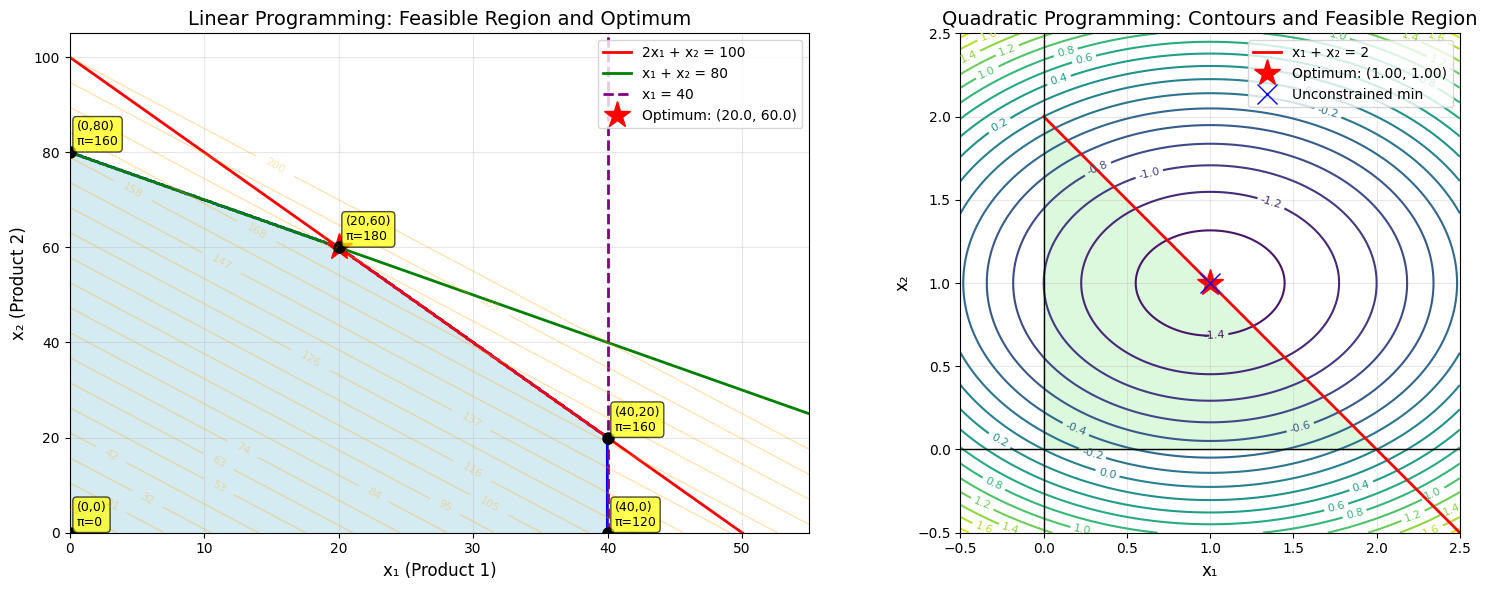

In [8]:
# Create visualization of feasible region
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ===== Plot 1: Detailed Feasible Region =====
ax1 = axes[0]

# Create grid
x1 = np.linspace(0, 60, 500)
x2 = np.linspace(0, 100, 500)
X1, X2 = np.meshgrid(x1, x2)

# Define constraints
constraint1 = (2*X1 + X2 <= 100)
constraint2 = (X1 + X2 <= 80)
constraint3 = (X1 <= 40)
constraint4 = (X1 >= 0)
constraint5 = (X2 >= 0)

# Feasible region is intersection of all constraints
feasible = constraint1 & constraint2 & constraint3 & constraint4 & constraint5

# Plot feasible region
ax1.contourf(X1, X2, feasible.astype(int), levels=[0.5, 1.5],
             colors=['lightblue'], alpha=0.5)
ax1.contour(X1, X2, feasible.astype(int), levels=[0.5],
            colors=['blue'], linewidths=2)

# Plot constraint lines
x1_line = np.linspace(0, 60, 200)

# Constraint 1: 2x1 + x2 = 100
x2_c1 = 100 - 2*x1_line
ax1.plot(x1_line, x2_c1, 'r-', linewidth=2, label='2x₁ + x₂ = 100')

# Constraint 2: x1 + x2 = 80
x2_c2 = 80 - x1_line
ax1.plot(x1_line, x2_c2, 'g-', linewidth=2, label='x₁ + x₂ = 80')

# Constraint 3: x1 = 40
ax1.axvline(x=40, color='purple', linewidth=2, linestyle='--', label='x₁ = 40')

# Plot objective function contours
Z = 3*X1 + 2*X2
levels = np.linspace(0, 200, 20)
contour = ax1.contour(X1, X2, Z, levels=levels, colors='orange',
                      alpha=0.3, linewidths=1)
ax1.clabel(contour, inline=True, fontsize=8, fmt='%.0f')

# Plot optimal solution
ax1.plot(lp_result.x[0], lp_result.x[1], 'r*', markersize=20,
         label=f'Optimum: ({lp_result.x[0]:.1f}, {lp_result.x[1]:.1f})')

# Find and plot corner points
corner_points = [
    (0, 0),
    (0, 80),
    (20, 60),  # Intersection of constraints 1 and 2
    (40, 20),  # Intersection of constraint 3 and 1
    (40, 0)
]

for i, (x1_p, x2_p) in enumerate(corner_points):
    profit = 3*x1_p + 2*x2_p
    ax1.plot(x1_p, x2_p, 'ko', markersize=8)
    ax1.annotate(f'({x1_p:.0f},{x2_p:.0f})\nπ={profit:.0f}',
                xy=(x1_p, x2_p), xytext=(5, 5),
                textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow',
                         alpha=0.7))

ax1.set_xlim([0, 55])
ax1.set_ylim([0, 105])
ax1.set_xlabel('x₁ (Product 1)', fontsize=12)
ax1.set_ylabel('x₂ (Product 2)', fontsize=12)
ax1.set_title('Linear Programming: Feasible Region and Optimum', fontsize=14)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# ===== Plot 2: Quadratic Programming Visualization =====
ax2 = axes[1]

# Create grid for QP problem
x1_qp = np.linspace(-0.5, 2.5, 300)
x2_qp = np.linspace(-0.5, 2.5, 300)
X1_qp, X2_qp = np.meshgrid(x1_qp, x2_qp)

# Objective function for QP
Z_qp = 0.5 * (X1_qp**2 + 2*X2_qp**2) - X1_qp - 2*X2_qp

# Plot objective function contours
contour_qp = ax2.contour(X1_qp, X2_qp, Z_qp, levels=20, cmap='viridis')
ax2.clabel(contour_qp, inline=True, fontsize=8, fmt='%.1f')

# Feasible region for QP
qp_constraint1_mask = (X1_qp + X2_qp <= 2)
qp_constraint2_mask = (X1_qp >= 0)
qp_constraint3_mask = (X2_qp >= 0)
qp_feasible = qp_constraint1_mask & qp_constraint2_mask & qp_constraint3_mask

# Shade feasible region
ax2.contourf(X1_qp, X2_qp, qp_feasible.astype(int),
             levels=[0.5, 1.5], colors=['lightgreen'], alpha=0.3)

# Plot constraints
x1_qp_line = np.linspace(0, 2.5, 100)
x2_qp_line = 2 - x1_qp_line
ax2.plot(x1_qp_line, x2_qp_line, 'r-', linewidth=2, label='x₁ + x₂ = 2')
ax2.axhline(y=0, color='k', linewidth=1)
ax2.axvline(x=0, color='k', linewidth=1)

# Plot optimal solution
ax2.plot(qp_result['x'][0], qp_result['x'][1], 'r*',
         markersize=20, label=f'Optimum: ({qp_result["x"][0]:.2f}, '
                              f'{qp_result["x"][1]:.2f})')

# Plot unconstrained minimum (would be at gradient = 0)
x_unconstrained = np.array([1, 1])  # From ∇f = 0
ax2.plot(x_unconstrained[0], x_unconstrained[1], 'bx',
         markersize=15, linewidth=3, label='Unconstrained min')

ax2.set_xlim([-0.5, 2.5])
ax2.set_ylim([-0.5, 2.5])
ax2.set_xlabel('x₁', fontsize=12)
ax2.set_ylabel('x₂', fontsize=12)
ax2.set_title('Quadratic Programming: Contours and Feasible Region',
              fontsize=14)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

PART 6: 3D VISUALIZATION OF PENALTY FUNCTION

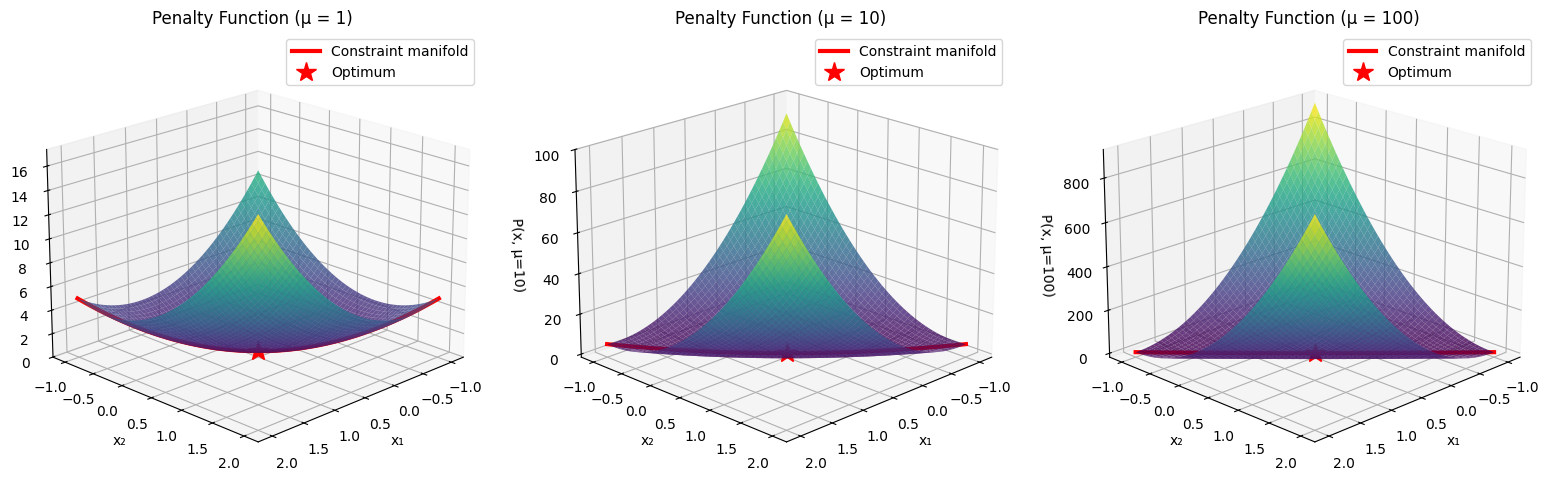

In [10]:
fig = plt.figure(figsize=(16, 5))

penalty_levels = [1, 10, 100]

for idx, mu in enumerate(penalty_levels):
    ax = fig.add_subplot(1, 3, idx+1, projection='3d')

    # Create grid
    x1_3d = np.linspace(-1, 2, 100)
    x2_3d = np.linspace(-1, 2, 100)
    X1_3d, X2_3d = np.meshgrid(x1_3d, x2_3d)

    # Calculate penalty function values
    Z_penalty = np.zeros_like(X1_3d)
    for i in range(X1_3d.shape[0]):
        for j in range(X1_3d.shape[1]):
            x = np.array([X1_3d[i,j], X2_3d[i,j]])
            # Objective: x^2 + y^2
            obj = x[0]**2 + x[1]**2
            # Constraint: x + y - 1 = 0
            constraint_violation = (x[0] + x[1] - 1)**2
            Z_penalty[i,j] = obj + mu * constraint_violation

    # Plot surface
    surf = ax.plot_surface(X1_3d, X2_3d, Z_penalty, cmap='viridis',
                          alpha=0.8, edgecolor='none')

    # Plot constraint manifold
    x1_constraint = np.linspace(-1, 2, 50)
    x2_constraint = 1 - x1_constraint
    z_constraint = x1_constraint**2 + x2_constraint**2
    ax.plot(x1_constraint, x2_constraint, z_constraint, 'r-',
            linewidth=3, label='Constraint manifold')

    # Plot optimum
    ax.plot([0.5], [0.5], [0.5], 'r*', markersize=15, label='Optimum')

    ax.set_xlabel('x₁', fontsize=10)
    ax.set_ylabel('x₂', fontsize=10)
    ax.set_zlabel(f'P(x, μ={mu})', fontsize=10)
    ax.set_title(f'Penalty Function (μ = {mu})', fontsize=12)
    ax.legend()

    # Set viewing angle
    ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

KEY INSIGHTS:
- Penalty methods are versatile but require careful parameter selection
- Specialized algorithms (like SLSQP, interior-point) often more efficient
- Visualization aids understanding of constraint geometry
- Constraint activity at optimum provides economic interpretation